# Smiley Project
- - -
Explainer notebook for final project in **Social data analysis and visualization (02806)**

17 May 2016

Authors:  
* **Emil Tyge**, s123259
* ...

- - -
Abstract:  
...

- - -
Content:  
* Imports
* Data Extraction and reformatting
* Initial data exploration
* Defining a Smiley rating
* Sectors with the worst smileys
* Name of a bad smiley
* Location of a bad smiley
* Timing of smiley inspections

- - -

Data sources:
* Smiley data, downloaded 17 Mar 2016
    From project website  
    http://www.findsmiley.dk/NR/exeres/FD95556E-E838-4850-BABA-7A6B21DF72E7.htm  
    Or as direct download  
    http://www.findsmiley.dk/xml/allekontrolresultater.xml
* Postcode map, downloaded 10 May 2016
    Retranslated from adresse-info.dk, and posted on the blog  
    http://www.microformats.dk/category/postnumre/  
    Direct Download  
    http://www.microformats.dk/kort/post/postnumre2008-07-01.zip  
* Population numbers, Danmarks Statistik PNR1 (free version of PNR2 with older data (2005)), downloaded 10 May 2016  
    http://www.statistikbanken.dk/10021
    

## Imports and definition

In [992]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import cluster
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
from __future__ import division
import random
import math
import xml.etree.ElementTree
import json

import geoplotlib
from geoplotlib.utils import BoundingBox

In [1000]:
# DEFINES

DEBUG = True
def log(s):
    if DEBUG:
        print s
        
EXTRACT_ALLEKONTROLRESULTATER = False

## Data Extraction and reformatting

The smiley data is available from the official project file as .xml or .xls
The xml is easy to read, but formatted with a lot of overhead. The data is extracted into a csv to reduce file size from 40Mb to 20 Mb and reduce loading times dramatically.

In [1001]:
if EXTRACT_ALLEKONTROLRESULTATER:
    # Load
    e = xml.etree.ElementTree.parse('../data/allekontrolresultater.xml').getroot()

    # Extract
    df = []
    for row in e.findall('row'):
        #print pd.DataFrame.from_dict([row.attrib])
        df.append(pd.DataFrame.from_dict([row.attrib]))
    df = pd.concat(df)

    # Save
    df.to_csv('../data/allekontrolresultater.csv', encoding="utf-8")
else:
    df = pd.read_csv('../data/allekontrolresultater.csv')

df.head()

,Unnamed: 0,By,Elite_Smiley,Geo_Lat,Geo_Lng,Kaedenavn,URL,adresse1,branche,brancheKode,cvrnr,fjerdeseneste_kontrol,fjerdeseneste_kontrol_dato,naestseneste_kontrol,naestseneste_kontrol_dato,navn1,navnelbnr,pixibranche,pnr,postnr,
0,0,Hvidovre,0,55.636857,12.479992,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Hvidovrevej 279,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,27091326,1,2011-03-29T13:14:00,2,2014-02-11T00:00:00,"Hvidovrevejens Minimarked,",100332829,Dagligvarer,1009790728,2650,...
1,0,Hårby,1,55.223351,10.123197,SuperBrugsen,http://www.findsmiley.dk/da-DK/Searching/Detai...,Algade 41,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,37176117,1,2009-08-03T14:40:00,1,2013-06-12T00:00:00,SuperBrugsen Dagligvarer,80202233,Dagligvarer,1003052316,5683,...
2,0,Karise,0,55.270005,12.220344,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Vemmetoftevej 2C,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,18455994,1,2013-12-11T00:00:00,2,2015-08-06T00:00:00,Lægårdens Minimarked,534601,Dagligvarer,1003444738,4653,...
3,0,Fakse,0,55.258005,12.119786,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Torvegade 20,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,36932902,NaN,NaN,NaN,NaN,Firkløveren,575181,Dagligvarer,1020510575,4640,...
4,0,Hirtshals,1,57.562734,10.029374,Kwik Spar,http://www.findsmiley.dk/da-DK/Searching/Detai...,"Allingdamvej 1, Åbyen","Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,16086533,1,2011-06-17T00:00:00,1,2014-02-04T00:00:00,KWIK SPAR,10364136,Dagligvarer,1001032059,9850,...


## Initial data exploration

First extraction of **basic statistics**, how much data is available

In [1002]:
def numAndPrc(x, tot):
    return "%s, (%.1f%%)" % (x,100*x/tot)

print "Number of records: %i" % len(df)
print "Records with cvr number: " + numAndPrc(sum(df.cvrnr.map(math.isnan)==False), len(df))
print "of these unique cvr numbers: " + numAndPrc(len(set(df.cvrnr)), sum(df.cvrnr.map(math.isnan)==False))

lat = df.Geo_Lat
lon = df.Geo_Lng
mask = (lat.map(math.isnan) == False) & (lat != 0)
print "Records with geo code: " + numAndPrc(sum(mask),len(df))

kontroller = np.sum(df[['seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']]
       .applymap(math.isnan) == False, axis=0)
print "Total records: %s" % sum(kontroller)
print "Records with one check: " + numAndPrc(kontroller.seneste_kontrol, len(df))
print "Records with two checks: " + numAndPrc(kontroller.naestseneste_kontrol, len(df))
print "Records with three checks: " + numAndPrc(kontroller.tredjeseneste_kontrol, len(df))
print "Records with four checks: " + numAndPrc(kontroller.fjerdeseneste_kontrol, len(df))
print "Records with elite smiley: " + numAndPrc(sum(df.Elite_Smiley == 1), len(df))
print "Smileys given %s" % Counter(df[['seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']].stack())
print "Top represented cities: %s" % Counter(df.By).most_common()[0:10]


Number of records: 57179
Records with cvr number: 56372, (98.6%)
of these unique cvr numbers: 34482, (61.2%)
Records with geo code: 54972, (96.1%)
Total records: 182008
Records with one check: 53255, (93.1%)
Records with two checks: 47539, (83.1%)
Records with three checks: 42699, (74.7%)
Records with four checks: 38515, (67.4%)
Records with elite smiley: 26762, (46.8%)
Smileys given Counter({1.0: 167302, 2.0: 12940, 4.0: 1360, 3.0: 406})
Top represented cities: [('K\xc3\xb8benhavn K', 1673), ('K\xc3\xb8benhavn V', 1174), ('\xc3\x85rhus C', 1161), ('K\xc3\xb8benhavn S', 1076), ('K\xc3\xb8benhavn \xc3\x98', 1037), ('Aalborg', 916), ('Odense C', 856), ('K\xc3\xb8benhavn N', 853), (nan, 744), ('Roskilde', 727)]


**Location** is a key part of the dataset, how are the inspections distributed spatially?

Cities are easily seen as hotspots in the data

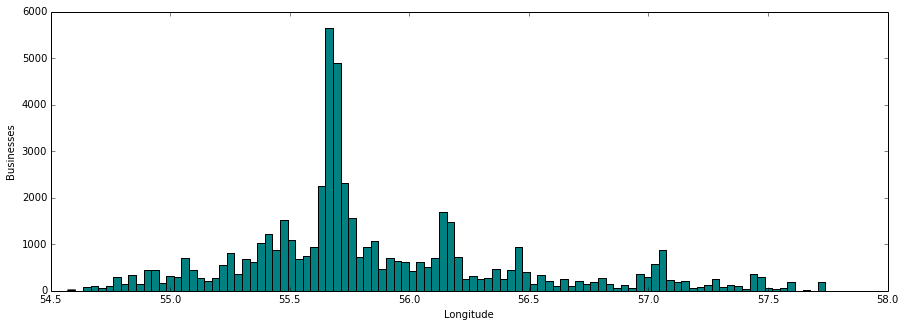

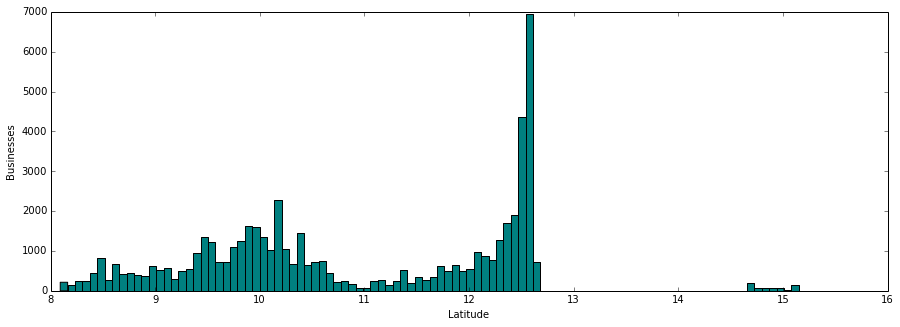

In [119]:
plt.figure(figsize=(15,5))
plt.hist(lat.loc[mask].tolist(), 100, color='teal');
plt.xlabel("Longitude");
plt.ylabel("Businesses");
plt.figure(figsize=(15,5))
plt.hist(lon.loc[mask].tolist(), 100, color='teal');
plt.xlabel("Latitude");
plt.ylabel("Businesses");

Even more visible on a **map**

In [990]:
geodata = {"lat": lat.loc[mask],
           "lon": lon.loc[mask]}
geoplotlib.dot(geodata, color='k');

geoplotlib.tiles_provider('toner-lite');
geoplotlib.set_bbox(BoundingBox(max(geodata['lat']), max(geodata['lon']), min(geodata['lat']), min(geodata['lon'])));
geoplotlib.show();

NameError: name 'lat' is not defined

In [223]:
What about the bad smileys, is it possible to see a difference in the location?

In [21]:
geodata = {"lat": lat.loc[mask & (df.seneste_kontrol > 1)],
           "lon": lon.loc[mask & (df.seneste_kontrol > 1)]}
geoplotlib.dot(geodata, color='k');

geoplotlib.tiles_provider('toner-lite');
geoplotlib.set_bbox(BoundingBox(max(geodata['lat']), max(geodata['lon']), min(geodata['lat']), min(geodata['lon'])));
geoplotlib.show();

Different smileys given


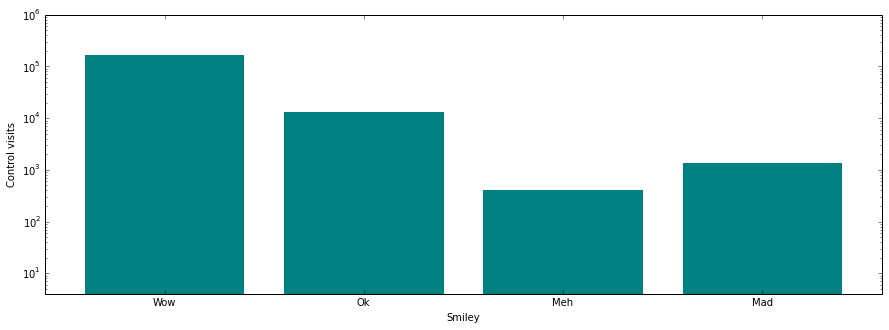

In [107]:
kontroller = df[['seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']]
print "Different smileys given"
v = Counter(kontroller.stack()).values()
plt.figure(figsize=(15,5))
plt.bar([0.6, 1.6, 2.6, 3.6],v, [0.8,0.8,0.8,0.8],4, log = True, color='teal', edgecolor='none');
plt.ylim([0,1e6])
plt.xlim([0.4,4.6])
plt.xticks([1,2,3,4], ['Wow','Ok','Meh','Mad']);
plt.ylabel('Control visits');
plt.xlabel('Smiley');


In [1005]:

rating = df[['seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']].astype(float).mean(axis=1)


# Extract all names
names = df.navn1.str.lower().str.split(" ")
flattened = [word for name in names for word in name]
namesAll = dict(Counter(flattened))

# Extract bad names
mask = rating > 1.5;
names = df.loc[mask].navn1.str.lower().str.split(" ")
flattened = [word for name in names for word in name]
namesBad = dict(Counter(flattened))

#plt.hist(rating.loc[rating.isnull() == False], log=True);
#print "%s businesses " % len(names)



In [1006]:
buf = {}
for key, value in namesBad.iteritems():
    if namesAll[key]>5:
        buf[key] =  value/namesAll[key]

#Counter(buf).most_common()

In [1057]:
buf = {}
for key, value in namesBad.iteritems():
    try:
        mask = df.navn1.str.lower().str.contains(key)
        #print key
        if sum(mask) > 3:
            buf[key] = np.mean(rating.loc[mask])
    except:
        # catch regex error's
        None

In [1070]:
worstNames = pd.DataFrame(Counter(buf).most_common(), columns=['navn','rating'])
worstNames[:50].to_csv('../data/worstSmileyNames.csv', index=False)
worstNames[:50]

,navn,rating
0,slikkepinden,3.555556
1,levin,2.000000
2,1001,1.883333
3,sodavand,1.833333
4,nara,1.833333
5,active,1.812500
6,silas,1.812500
7,pleje-enheden,1.750000
8,beirut,1.750000
9,bazaren,1.750000


In [198]:
df.loc[rating > 3][['navn1','adresse1','By','seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']]

,navn1,adresse1,By,seneste_kontrol,naestseneste_kontrol,tredjeseneste_kontrol,fjerdeseneste_kontrol
893,Ølby Bazar Kolonial,Ølbycenter 17,Køge,4,2,4,4
1468,Dan køb v/Rodin Ahmad,Dumpen 20,Viborg,1,4,4,4
2235,Istanbul Bazar Dagligvarer,Frederiksborgvej 17-19,København NV,4,4,4,4
2598,Bulgarien Import Export I/S,"Åboulevard 32, st",København N,4,4,4,4
2797,SUPER SPAR Dagligvarer,Persillehaven 111,Herlev,1,4,4,4
6272,Zamani Fiskebil Reg.nr.:DG 93125,Østervej 63,Glostrup,4,4,1,4
6435,Al Zahraa Marked,Nørrebrogade 249,København N,4,4,4,2
7566,JRZ International Broker v/ Johan R. Zerlang,"Palægade 5, 4",København K,4,NaN,NaN,NaN
8758,Mobis Danmark ApS,Grønttorvet 6,Valby,4,3,NaN,NaN
8874,FMK Food,Gjellerupvej 102,Brabrand,3,4,NaN,NaN


In [192]:
Counter([x[0:4] for x in df.fjerdeseneste_kontrol_dato if type(x) is str])

Counter({'2000': 1,
         '2002': 1,
         '2003': 11,
         '2004': 288,
         '2005': 370,
         '2006': 379,
         '2007': 447,
         '2008': 947,
         '2009': 2776,
         '2010': 5092,
         '2011': 4366,
         '2012': 7199,
         '2013': 7658,
         '2014': 6414,
         '2015': 2643,
         '2016': 8})

In [ ]:
# geocode api
#http://maps.google.com/maps/api/geocode/json?&components=country:DK&address=jensen

In [234]:
# Weight histogram
mask = (rating.map(math.isnan)==False)
Counter(rating.loc[mask].tolist())

Counter({1.0: 41158,
         1.25: 7221,
         1.3333333333333333: 879,
         1.5: 2198,
         1.6666666666666667: 140,
         1.75: 580,
         2.0: 706,
         2.25: 111,
         2.3333333333333335: 40,
         2.5: 107,
         2.6666666666666665: 7,
         2.75: 39,
         3.0: 31,
         3.25: 14,
         3.3333333333333335: 3,
         3.5: 9,
         3.75: 3,
         4.0: 13})

In [ ]:
# Branche med værst smileyer

In [343]:
mask = (rating.map(math.isnan)==False)
brancheSmiley = pd.concat([df.pixibranche, rating], axis=1)
brancheSmiley.columns = ['branche', 'rating']
brancheSmiley = brancheSmiley.loc[mask]

df2 = []
for branche in set(df.pixibranche):
    mask2 = brancheSmiley.branche == branche
    df2.append([branche, np.mean(brancheSmiley.rating.loc[mask2]), sum(mask2)])
    
df2 = pd.DataFrame(df2, columns=['branche','rating','antal'])

In [349]:
print df2.sort(['rating'],ascending = [False])

                                              branche    rating  antal
32    Virksomheder, engros-branche endnu ikke tildelt  1.364286     70
21    Virksomheder, detail-branche endnu ikke tildelt  1.279245    265
17                           Salater, dressinger m.m.  1.166667     15
1                         Frugt- og grøntforretninger  1.150433    308
37                              Værtshuse og bodegaer  1.144336   1948
24                          Bagere og bagerafdelinger  1.135153   1145
39               Chokolade- og konfektureforretninger  1.131705    696
19                                                 Æg  1.125000      4
0                                         Dagligvarer  1.120332   5079
33                                    Vinforretninger  1.118114    472
16                                Brød, kager og kiks  1.110380    114
45                          Apoteker og materialister  1.103749    947
42                                            Kiosker  1.101400   1559
14    

In [348]:
mask = df.branche == 'Fart\xc3\xb8jer: Fabriksfart\xc3\xb8jer'
df.loc[mask]

,Unnamed: 0,By,Elite_Smiley,Geo_Lat,Geo_Lng,Kaedenavn,URL,adresse1,branche,brancheKode,cvrnr,fjerdeseneste_kontrol,fjerdeseneste_kontrol_dato,naestseneste_kontrol,naestseneste_kontrol_dato,navn1,navnelbnr,pixibranche,pnr,postnr,
5598,0,Thyborøn,1,56.700002,8.208884,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Havnegade 62,Fartøjer: Fabriksfartøjer,10.20.20.D,33178808,1,2012-11-28T00:00:00,1,2014-09-24T00:00:00,L 120 Linette,30706278,Fabriksfartøjer,1016387912,7680,...
5616,0,Neksø,0,55.062263,15.133714,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Strandgade 10,Fartøjer: Fabriksfartøjer,10.20.20.D,17631047,1,2014-11-06T00:00:00,2,2016-01-25T00:00:00,"M/TR ""Ocean Tiger"" V/Partsrederiet Ocean Tiger...",10364319,Fabriksfartøjer,1001327733,3730,...


In [281]:
# Predict next smiley
kontroller = df[['tredjeseneste_kontrol','fjerdeseneste_kontrol']]#,'tredjeseneste_kontrol','fjerdeseneste_kontrol']]
for checkRating in range(1,5):
    print "\n%u:" % checkRating
    mask = (kontroller.iloc[:,1] == checkRating) & (kontroller.iloc[:,0].map(math.isnan)==False)
    n = sum(mask)
    print "n = %u" % n
    print [x/n for x in Counter(kontroller.iloc[:,0].loc[mask]).values()]



1:
n = 34563
[0.91097416312241419, 0.08338396551225298, 0.0014466336834186848, 0.0041952376819141858]

2:
n = 3436
[0.82072176949941789, 0.11816065192083819, 0.012514551804423749, 0.048603026775320142]

3:
n = 129
[0.75193798449612403, 0.093023255813953487, 0.093023255813953487, 0.062015503875968991]

4:
n = 382
[0.7172774869109948, 0.11518324607329843, 0.015706806282722512, 0.15183246073298429]


0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
...
57164    1
57165    1
57166    1
57167    1
57168    1
57169    1
57170    1
57171    1
57172    1
57173    1
57174    1
57175    1
57176    1
57177    1
57178    1
Name: seneste_kontrol, Length: 57179, dtype: float64


In [1008]:
# Area of geojson polygon
from math import pi, sin

WGS84_RADIUS = 6378137

def rad(value):
    return value * pi / 180

def ring__area(coordinates):
    """
    Calculate the approximate _area of the polygon were it projected onto
        the earth.  Note that this _area will be positive if ring is oriented
        clockwise, otherwise it will be negative.
    Reference:
        Robert. G. Chamberlain and William H. Duquette, "Some Algorithms for
        Polygons on a Sphere", JPL Publication 07-03, Jet Propulsion
        Laboratory, Pasadena, CA, June 2007 http://trs-new.jpl.nasa.gov/dspace/handle/2014/40409
    @Returns
    {float} The approximate signed geodesic _area of the polygon in square meters.
    """

    assert isinstance(coordinates, list)

    _area = 0
    coordinates_length = len(coordinates)

    if coordinates_length > 2:
        for i in range(0, coordinates_length):
            if i == (coordinates_length - 2):
                lower_index = coordinates_length - 2
                middle_index = coordinates_length - 1
                upper_index = 0
            elif i == (coordinates_length - 1):
                lower_index = coordinates_length - 1
                middle_index = 0
                upper_index = 1
            else:
                lower_index = i
                middle_index = i + 1
                upper_index = i + 2

            p1 = coordinates[lower_index]
            p2 = coordinates[middle_index]
            p3 = coordinates[upper_index]

            _area += (rad(p3[0]) - rad(p1[0])) * sin(rad(p2[1]))

        _area = _area * WGS84_RADIUS * WGS84_RADIUS / 2

    return _area

def polygon__area(coordinates):

    assert isinstance(coordinates, list)

    _area = 0
    if len(coordinates) > 0:
        _area += abs(ring__area(coordinates[0]))

        for i in range(1, len(coordinates)):
            _area -= abs(ring__area(coordinates[i]))

    return _area


def area(geometry):

    if isinstance(geometry, str):
        geometry = json.loads(geometry)

    assert isinstance(geometry, dict)

    _area = 0

    if geometry['type'] == 'Polygon':
        return polygon__area(geometry['coordinates'])
    elif geometry['type'] == 'MultiPolygon':
        for i in range(0, len(geometry['coordinates'])):
            _area += polygon__area(geometry['coordinates'][i])

    elif geometry['type'] == 'GeometryCollection':
        for i in range(0, len(geometry['geometries'])):
            _area += area(geometry['geometries'][i])

    return _area

In [1009]:
# Load data
with open('../data/postnumre2008-07-01.geojson') as data_file:    
    mapdata = json.load(data_file)

befolkning = pd.read_csv('../data/PNR1_2005_befolkning.csv')

# Extract postnummer
befolkning['Postnummer'] = [int(s[0:4]) for s in befolkning.Navn]

# Match postnummer and extend geojson data
for feature in mapdata['features']:
    # print progress
    print feature['properties']['Description'].split('<td>')[1].split('</td>')[0]
    
    # Extract groups of postnummer and create masks
    pgroup = feature['properties']['Name'].split(' - ')
    if (len(pgroup) > 1):
        mask = (int(pgroup[0]) <= befolkning.Postnummer) & (befolkning.Postnummer <= int(pgroup[1]))
        dfmask = (int(pgroup[0]) <= df.postnr) & (df.postnr <= int(pgroup[1]))
    else:
        mask = befolkning.Postnummer == int(pgroup[0])
        dfmask = df.postnr == int(pgroup[0])
    
    # clean and extend geojson
    feature['properties']['Indbyggere']  = sum(befolkning.loc[mask].Indbyggere)
    feature['properties']['Description'] = feature['properties']['Description'].split('<td>')[1].split('</td>')[0]
    feature['properties']['Areal']       = area(feature['geometry'])/1e6
    feature['properties']['SmileyVirksomheder'] = sum(dfmask)
    feature['properties']['MostCommonPixi'] = Counter(df.loc[dfmask].pixibranche).most_common()[0][0]
    feature['properties']['AverageSmiley'] = np.mean(rating.loc[dfmask])

with open('../data/postnumre_clean.geojson', 'w') as fp:
    json.dump(mapdata, fp)

København K
København V
Frederiksberg C
Frederiksberg
København Ø
København N
København S
København NV
København SV
Valby
Glostrup
Brøndby
Rødovre
Albertslund
Vallensbæk
Taastrup
Ishøj
Hedehusene
Hvidovre
Brøndby Strand
Vallensbæk Strand
Greve
Solrød
Karlslunde
Brønshøj
Vanløse
Herlev
Skovlunde
Ballerup
Måløv
Smørum
Kastrup
Dragør
Kongens Lyngby
Gentofte
Virum
Holte
Nærum
Søborg
Dyssegård
Bagsværd
Hellerup
Charlottenlund
Klampenborg
Skodsborg
Vedbæk
Rungsted Kyst
Hørsholm
Kokkedal
Nivå
Helsingør
Humlebæk
Humlebæk
Espergærde
Snekkersten
Tikøb
Hornbæk
Dronningmølle
Ålsgårde
Hellebæk
Helsinge
Vejby
Tisvildeleje
Græsted
Gilleleje
Frederiksværk
Ølsted
Skævinge
Gørløse
Liseleje
Melby
Hundested
Hillerød
Allerød
Birkerød
Fredensborg
Kvistgård
Værløse
Farum
Lynge
Slangerup
Frederikssund
Jægerspris
Ølstykke
Stenløse
Veksø Sjælland
Rønne
Aakirkeby
Neksø
Svaneke
Østermarie
Gudhjem
Allinge
Klemensker
Hasle
Roskilde
Tune
Jyllinge
Skibby
Kirke Såby
Kirke Hyllinge
Ringsted
Viby Sjælland
Borup
Herlufma

In [1010]:

for feature in mapdata['features']:
    # Extract groups of postnummer and sum data
    pgroup = feature['properties']['Name'].split(' - ')
    if (len(pgroup) > 1):
        mask = (int(pgroup[0]) <= df.postnr) & (df.postnr <= int(pgroup[1]))
    else:
        mask = df.postnr == int(pgroup[0]);
        
    ppa = feature['properties']['Indbyggere']/feature['properties']['Areal']
    ipa = sum(mask)/feature['properties']['Areal']
    
    print feature['properties']['Description']
    print ppa/ipa


København K
19.9080525414
København V
34.4983193277
Frederiksberg C
96.224025974
Frederiksberg
86.8393854749
København Ø
77.0395371263
København N
83.01992966
København S
88.5120817844
København NV
92.4205020921
København SV
65.4979253112
Valby
81.5587188612
Glostrup
66.005730659
Brøndby
63.198757764
Rødovre
115.636363636
Albertslund
128.178217822
Vallensbæk
174.833333333
Taastrup
82.6868686869
Ishøj
98.5837320574
Hedehusene
100.859375
Hvidovre
101.586419753
Brøndby Strand
144.142857143
Vallensbæk Strand
109.609375
Greve
121.636363636
Solrød
152.037735849
Karlslunde
80.3608247423
Brønshøj
125.472560976
Vanløse
119.232931727
Herlev
99.8138888889
Skovlunde
109.810810811
Ballerup
96.7450980392
Måløv
103.622222222
Smørum
194.740740741
Kastrup
94.3273657289
Dragør
129.504065041
Kongens Lyngby
110.925287356
Gentofte
107.289340102
Virum
185.925233645
Holte
150.97
Nærum
97.027027027
Søborg
87.6963190184
Dyssegård
217.307692308
Bagsværd
95.7931034483
Hellerup
88.984496124
Charlottenlund
106.432

KeyboardInterrupt: 

In [1011]:
# extract kontroller into one column
columns = ['','naest', 'tredje', 'fjerde']
kontroller = {};
for nc in range(0,len(columns)):
    # generate names
    column = columns[nc] + 'seneste_kontrol'
    nextColumn = columns[nc-1] + 'seneste_kontrol' if nc-1 >= 0 else None;
    
    # generate selector
    selector = [column, column + '_dato', 'postnr', 'Geo_Lat', 'Geo_Lng', 'pixibranche','Elite_Smiley'];
    if nextColumn:
        selector.extend([nextColumn+ '_dato'])
    
    # select data
    kontroller[column] = df[selector]

    #rename
    kontroller[column].rename(columns={column: 'kontrol', column + '_dato': 'dato'}, inplace=True)
    if nextColumn:
        kontroller[column].rename(columns={nextColumn + '_dato': 'next_dato'}, inplace=True)
# concat dict
kontroller = pd.concat(kontroller)
# remove nans
kontroller = kontroller.loc[kontroller.kontrol.map(math.isnan) == False]

branchelabels = {label: i for i, label in enumerate(set(kontroller.pixibranche))}
kontroller['pixibranche_id'] = kontroller.pixibranche.map(lambda b: labels[b])

kontroller['deltat'] = pd.to_datetime(kontroller.next_dato)-pd.to_datetime(kontroller.dato)
kontroller['deltat'] = kontroller['deltat'].map(lambda x: x / np.timedelta64(1,'D'));

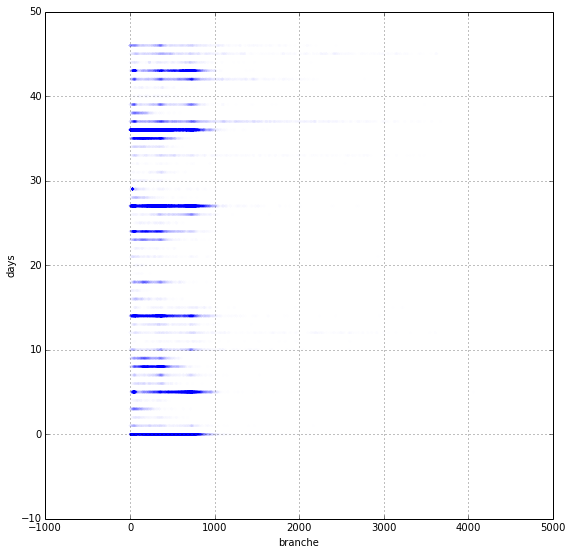

In [493]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.scatter(kontroller.deltat, kontroller.pixibranche_id, alpha=0.005);
plt.ylabel('branche')
#plt.xlim(0,24);
plt.xlabel("days")
#plt.ylim(0,24);
plt.grid(True)

In [1012]:
nanmask = kontroller.deltat.map(math.isnan) == False
bins = range(0,1000,4*7)
histdata = {'bins':bins}
histdata['items'] = []
for branche in branchelabels:
    b_id = branchelabels[branche]
    
    buf = {}
    buf['deltatHist'] = {}
    bdata = kontroller.loc[nanmask & (kontroller.pixibranche_id == b_id)]
    buf['antal'] = len(bdata)
    for i in range(0,5):
        if i == 0: # elite
            d = np.histogram(bdata.loc[(bdata.Elite_Smiley == 1)].deltat.map(round),bins)[0]
        else:
            d = np.histogram(bdata.loc[(bdata.kontrol == i) & ((bdata.Elite_Smiley != 1))].deltat.map(round),bins)[0]
        
        buf['deltatHist'][i] = d.tolist()
    buf['branche'] = branche;
    
    histdata['items'].append(buf);
    
    #histdata[branche] = {'hist':d, 'total':len(data)}
    #plt.plot(bins[1:] - np.diff(bins)/2, d/sum(d))

#kontroller.pixibranche_id
#np.histogram(kontroller.loc[mask].deltat.map(round), 1000)

In [804]:
#bdata = kontroller.loc[nanmask & (kontroller.pixibranche_id == branchelabels['Kiosker'])]
#bdata.loc[(bdata.kontrol == 1) & ((bdata.Elite_Smiley != 1))]
#df.ix[11792].URL

In [852]:

with open('../data/kontroltid_hist_data.json', 'w') as fp:
    json.dump(histdata, fp)

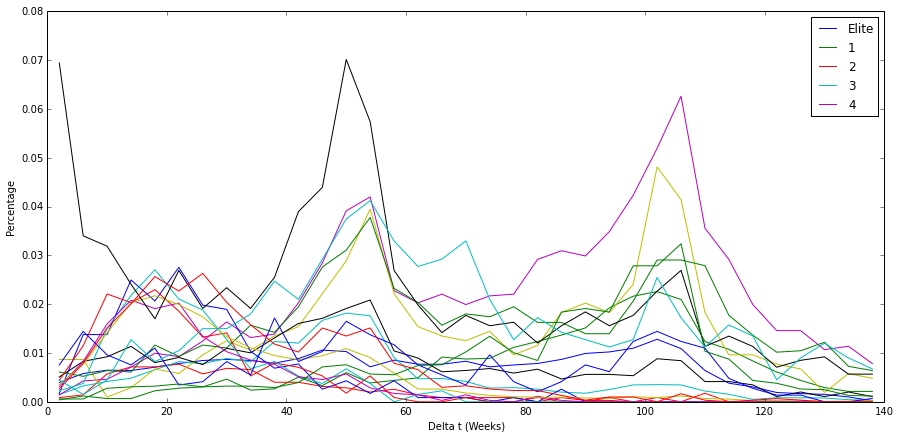

In [1052]:

plt.figure(figsize=(15,7))
for d in histdata['items'][1:]:
    #print d
    #print d['branche']
    if d['antal'] > 1000:
        for i in range(1,2):
            plt.plot((histdata['bins'][1:] - np.diff(histdata['bins'])/2)/7, np.asarray(d['deltatHist'][i])/d['antal'])

plt.legend(["Elite", '1', '2', '3','4'])
#plt.ylim(0,0.2);
plt.xlabel("Delta t (Weeks)")
plt.ylabel("Percentage")

In [1044]:
buf = [(np.asarray(x['deltatHist'].values())/x['antal']).ravel().tolist() for x in histdata['items']]
buf = np.asarray(buf)
np.savetxt("deltat_hist_feature_data.csv", buf, delimiter=",")

Grouping is done with K-Means in matlab as the scikit learn K-Means implementation dows not include the possibility of a custum distance measure.

The wanted distance measure is the cosine similarity, which is good at detecting shapes in vector data as it ignores the scaling.
The cosine similarity is a measure of angular distance in the n-dimensional vector space that is the training data.

The following Matlab code is run to cluster on the timing of the happy smiley inspections
- - -
```
% Import data into matlab
uiimport

%  display import
display(feature_import)

% cluster using cosine similarity
n_groups = 4
[group, shapes] = kmeans(feature_import(:,36:69), ...
    n_groups, 'Replicates', 10, 'Distance', 'cosine');
```
- - -

In [348]:
mask = (kontroller.kontrol == 4) & (kontroller.Geo_Lat.map(math.isnan) == False) & (kontroller.Geo_Lat != False)
geodata = {"lat": kontroller.loc[mask].Geo_Lat,
           "lon": kontroller.loc[mask].Geo_Lng}
X = kontroller.loc[mask][['Geo_Lng', 'Geo_Lat']]
mdl3 = cluster.KMeans(n_clusters=50).fit(X)

centroids = {"lat": mdl3.cluster_centers_[:,1],
           "lon": mdl3.cluster_centers_[:,0]}

#geoplotlib.kde(geodata, bw=5, cut_below=1e-2);
geoplotlib.dot(geodata, color ='r', point_size=1);
geoplotlib.dot(centroids, color ='b', point_size=3);

geoplotlib.tiles_provider('toner-lite');
geoplotlib.set_bbox(BoundingBox(max(geodata['lat']), max(geodata['lon']), min(geodata['lat']), min(geodata['lon'])));
geoplotlib.inline();

In [875]:
df.loc[rating > 1.5]
#.to_csv('../data/beware_list.csv', encoding="utf-8")

,Unnamed: 0,By,Elite_Smiley,Geo_Lat,Geo_Lng,Kaedenavn,URL,adresse1,branche,brancheKode,cvrnr,fjerdeseneste_kontrol,fjerdeseneste_kontrol_dato,naestseneste_kontrol,naestseneste_kontrol_dato,navn1,navnelbnr,pixibranche,pnr,postnr,
15,0,Aalborg,0,57.044022,9.918614,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Boulevarden 33 B,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,32792308,2,2014-01-16T00:00:00,4,2015-10-12T00:00:00,Safari Expert v/Mohamed Hassan Guled,10978029,Dagligvarer,1015948821,9000,...
23,0,Århus V,0,NaN,NaN,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Frydenlund Alle 15,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,34759146,3,2014-12-19T00:00:00,4,2015-06-08T00:00:00,Mayadas Mini Marked,523671,Dagligvarer,1018160354,8210,...
38,0,København S,0,55.661268,12.623028,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Øresundsvej 114,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,20749938,NaN,NaN,2,2015-04-16T00:00:00,Kiosk 114,561515,Dagligvarer,1020368507,2300,...
74,0,Holstebro,0,56.315589,8.605551,LetKøb,http://www.findsmiley.dk/da-DK/Searching/Detai...,Sognstrupvej 4,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,14015590,NaN,NaN,NaN,NaN,Let-Køb Nr. Felding,572692,Dagligvarer,1020766863,7500,...
83,0,Lyngby,0,55.793303,12.512363,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Kulsviervej 73,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,36901101,1,2015-07-27T00:00:00,2,2016-01-11T00:00:00,wide mini market,573299,Dagligvarer,1020817360,2800,...
97,0,Odense V,0,55.393990,10.333414,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,"Juelsmindevej 11, st","Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,33807147,1,2015-03-16T00:00:00,4,2015-09-01T00:00:00,EuroDeli Odense,558509,Dagligvarer,1020112472,5200,...
122,0,Frederiksberg C,0,55.682396,12.551120,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Rosenørns Alle 34,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,35782605,NaN,NaN,2,2015-07-28T00:00:00,X-Camp,566815,Dagligvarer,1019440601,1970,...
135,0,Kolding,0,55.490636,9.473195,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Adelgade 1,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,29571104,2,2015-06-09T00:00:00,1,2015-09-01T00:00:00,Michella's Frugt og Grønt V/Ismail Alizadeh,50831138,Dagligvarer,1016243163,6000,...
147,0,København V,0,55.668637,12.552100,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Istedgade 73,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,26517338,1,2014-08-25T00:00:00,3,2015-04-27T00:00:00,Al-Amim Minimarked v/ Muhammad A. Al-Kaaby,110355929,Dagligvarer,1008120427,1650,...
205,0,Lyngby,0,55.770251,12.509155,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Nørgaardsvej 18A,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,18181991,4,2013-05-07T00:00:00,1,2014-02-20T00:00:00,Den Fri Købmand,100683829,Dagligvarer,1009850674,2800,...
